In [1]:
cd ..

/wk171/boyochen/dltc


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from main import get_tensorflow_datasets
from modules.training_helper import get_sample_data, rotation_blending

In [3]:
%env CUDA_VISIBLE_DEVICES=1

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(
        gpu,
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)]
    )

env: CUDA_VISIBLE_DEVICES=1


In [4]:
datasets = get_tensorflow_datasets(
    data_folder='TCSA_data/',
    batch_size=1000,
    shuffle_buffer=100000,
    prefetch_buffer=2,
    good_VIS_only=False,
    coordinate='polar'
)

In [5]:
from modules.training_helper import replace_original_channel_with_generation

In [6]:
from main import create_model_by_experiment_settings, prepare_model_save_path

experiment_name = 'W_and_F_GAN_profiler_5stage'
sub_exp_name = 'pretrain_profiler_all_data_stage'
sub_exp_settings = {
    'compound_model':{
        'generator': 'generator_4_1',
        'discriminator': 'discriminator_2_1',
        'profiler': 'profiler_4_4'
    }
}

_, compound_model = create_model_by_experiment_settings(
    sub_exp_settings,
    load_from=prepare_model_save_path(experiment_name, sub_exp_name)
)

#noon_image = compound_model.generate_noon_image(sample_image, sample_feature, training=False)

In [9]:
total_Vmax = 0
for images, feature, profile, Vmax, R34 in datasets['train']:
    total_Vmax += tf.reduce_sum(Vmax)
total_Vmax

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


<tf.Tensor: shape=(), dtype=float32, numpy=2405213.5>

In [10]:
%time ds2 = replace_original_channel_with_generation(datasets, compound_model.generator, replace_VIS=True, replace_PMW=False)

CPU times: user 10min 7s, sys: 12.4 s, total: 10min 19s
Wall time: 10min 9s


In [12]:
total_Vmax = 0
for images, feature, profile, Vmax, R34 in ds2['train']:
    total_Vmax += tf.reduce_sum(Vmax)
total_Vmax

<tf.Tensor: shape=(), dtype=float32, numpy=2405213.5>

In [32]:
generator = compound_model.generator
replace_VIS = True
replace_PMW = False

In [34]:
from collections import defaultdict

def unpack_tensorflow_dataset(dataset):
    batch_list_dict = defaultdict(list)
    for batch_index, (images, feature, profile, Vmax, R34) in dataset.enumerate():
        batch_list_dict['images'].append(images)
        batch_list_dict['feature'].append(feature)
        batch_list_dict['profile'].append(profile)
        batch_list_dict['Vmax'].append(Vmax)
        batch_list_dict['R34'].append(R34)
    tensors = {
        column: tf.concat(batch_list, axis=0)
        for column, batch_list in batch_list_dict.items()
    }
    return tensors

def replace_channel_by_fixed_generation(generator, images, feature, replace_VIS, replace_PMW):
    generated_VIS, generated_PMW = generator(images, feature)
    IR1_WV = tf.gather(images, axis=-1, indices=[0, 1])
    VIS = generated_VIS if replace_VIS else tf.gather(images, axis=-1, indices=[2])
    PMW = generated_PMW if replace_PMW else tf.gather(images, axis=-1, indices=[3])
    new_image = tf.concat([IR1_WV, VIS, PMW], axis=-1)
    return new_image.numpy()

In [7]:
phase = 'train'

In [24]:
batched_datasets = datasets[phase]
shuffled_datasets = batched_datasets._input_dataset
zipped_datasets = shuffled_datasets._input_dataset
images_dataset = zipped_datasets._datasets[0]
feature_dataset = zipped_datasets._datasets[1]
profile_dataset = zipped_datasets._datasets[2]
Vmax_dataset = zipped_datasets._datasets[3]
R34_dataset = zipped_datasets._datasets[4]

In [35]:
L = []
for images, feature in tf.data.Dataset.zip((images_dataset, feature_dataset)).batch(100):
    L.append(
        replace_channel_by_fixed_generation(
            generator, images, feature,
            replace_VIS, replace_PMW
        )
    )

In [41]:
import numpy as np
images_tensor = np.concatenate(L)

In [42]:
images_tensor.shape

(54784, 180, 103, 4)

In [48]:
buffer_size = datasets['train'].prefetch(2)._buffer_size

In [51]:
datasets['train'].prefetch(buffer_size)._buffer_size

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [5]:
from modules.feature_generator import load_dataset

In [6]:
total_Vmax = 0
for batch_index, (images, feature, profile, Vmax, R34) in ds2['train'].enumerate():
    print(batch_index)
    total_Vmax += tf.reduce_sum(Vmax)
total_Vmax

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(15, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(17, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(20, shape=(), dtype=int64)
tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor(22, shape=(), dtype=int64)
tf.Tensor(23, shape=(), dtype=int64)
tf.Tensor(24, shape=(), dtype=int64)
tf.Tensor(25, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(2

<tf.Tensor: shape=(), dtype=float32, numpy=2405213.0>

In [13]:
tf.concat([images, images], axis=0)

<tf.Tensor: shape=(1568, 180, 103, 4), dtype=float32, numpy=
array([[[[ 2.40389999e+02,  2.20960007e+02,  4.20000017e-01,
           5.06965780e+00],
         [ 2.57314148e+02,  2.29272369e+02,  3.55877370e-01,
           5.37149858e+00],
         [ 2.71119019e+02,  2.36470535e+02,  3.23361248e-01,
           5.67207623e+00],
         ...,
         [ 2.68660339e+02,  2.37907837e+02,  3.95514667e-01,
           1.48216769e-01],
         [ 2.70031677e+02,  2.38956985e+02,  3.63756627e-01,
           1.36510655e-01],
         [ 2.70276794e+02,  2.39494217e+02,  3.55181813e-01,
           1.32050574e-01]],

        [[ 2.40389999e+02,  2.20960007e+02,  4.20000017e-01,
           5.06965780e+00],
         [ 2.57451569e+02,  2.29344360e+02,  3.54497999e-01,
           5.37531614e+00],
         [ 2.70889954e+02,  2.36464844e+02,  3.22750539e-01,
           5.68000841e+00],
         ...,
         [ 2.70666595e+02,  2.39469666e+02,  4.25645709e-01,
           9.71289277e-02],
         [ 2.703725

In [ ]:
total_Vmax

In [27]:
from modules.image_processor import is_polar_coordinate, polar2cart

In [6]:
sample_data = {
    phase: get_sample_data(datasets[phase], 500)
    for phase in ['train', 'valid']
}

In [7]:
sample_image, sample_feature, sample_label = sample_data['valid']

In [23]:
label = sample_label
big_weight = (label ** 2)
sample_weight = big_weight / tf.reduce_sum(big_weight) * label.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [52]:
from main import create_model_by_experiment_settings, prepare_model_save_path

experiment_name = 'three_stage_training'
sub_exp_name = 'generator_good_VIS_only_stage'
sub_exp_settings = {
    'compound_model':{
        'generator': 'generator_3_2',
        'discriminator': 'discriminator_2_1',
        'regressor': 'regressor_1_3'
    }
}

L1_compound_model = create_model_by_experiment_settings(
    sub_exp_settings,
    load_from=prepare_model_save_path(experiment_name, sub_exp_name)
)

L1_noon_image = L1_compound_model.generate_noon_image(sample_image, sample_feature, training=False)

In [299]:
experiment_name = 'channel_composition'
sub_exp_name = 'IR1_PMW'
sub_exp_settings = {
    'regressor': 'regressor_5_2'
}

best_model = create_model_by_experiment_settings(
    sub_exp_settings,
    load_from=prepare_model_save_path(experiment_name, sub_exp_name)
)

In [51]:
experiment_name = 'five_stage_training'
sub_exp_name = 'regressor_finetune_stage'
sub_exp_settings = {
    'compound_model':{
        'generator': 'generator_3_2',
        'discriminator': 'discriminator_2_1',
        'regressor': 'regressor_1_3'
    }
}

L2_compound_model = create_model_by_experiment_settings(
    sub_exp_settings,
    load_from=prepare_model_save_path(experiment_name, sub_exp_name)
)

L2_noon_image = L2_compound_model.generate_noon_image(sample_image, sample_feature, training=False)

In [194]:
def scale_to_0_1(matrix):
    out = matrix - matrix.min()
    tmp_max = out.max()
    if tmp_max != 0:
        out /= tmp_max
    return out

def stick_into_big_matrix(image, target_index, width=4, target_channel_idx=2):
    random_select_num = width**2 - len(target_index)
    bound = image.shape[0]
    random_index = [np.random.randint(bound) for i in range(random_select_num)]
    selected_index = target_index+random_index
    print(selected_index)
    selected_image = tf.gather(image, axis=0, indices=selected_index)
    list_of_list_of_images = [
        [
            (selected_image[i*width+j, :, :, target_channel_idx].numpy())
            for j in range(width)
        ] for i in range(width)
    ]
    list_of_lines = [
        tf.concat(
            list_of_images, axis=1
        ) for list_of_images in list_of_list_of_images
    ]
    return tf.concat(list_of_lines, axis=0)

In [195]:
target_index=[0, 149, 319, 401, 192, 361, 261, 87, 42]
big_matrix = stick_into_big_matrix(sample_image, target_index, width=3)

plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()

[0, 149, 319, 401, 192, 361, 261, 87, 42]


[0, 149, 319, 401, 192, 361, 261, 87, 42]


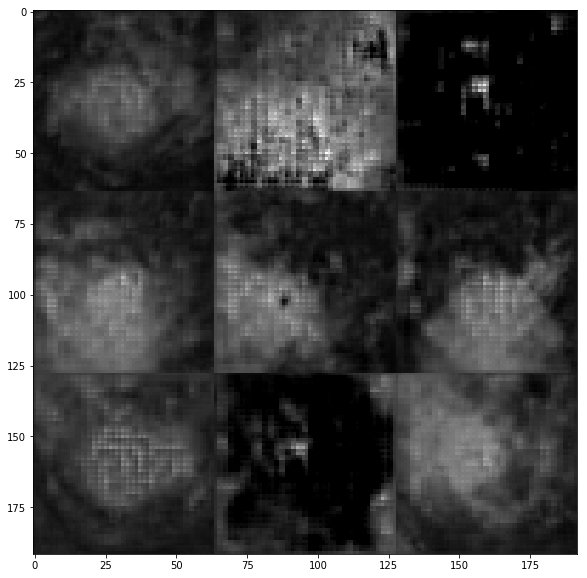

In [196]:
target_index=[0, 149, 319, 401, 192, 361, 261, 87, 42]
big_matrix = stick_into_big_matrix(noon_image, target_index, width=3)

plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()

[0, 42, 361, 192, 401, 261, 87]


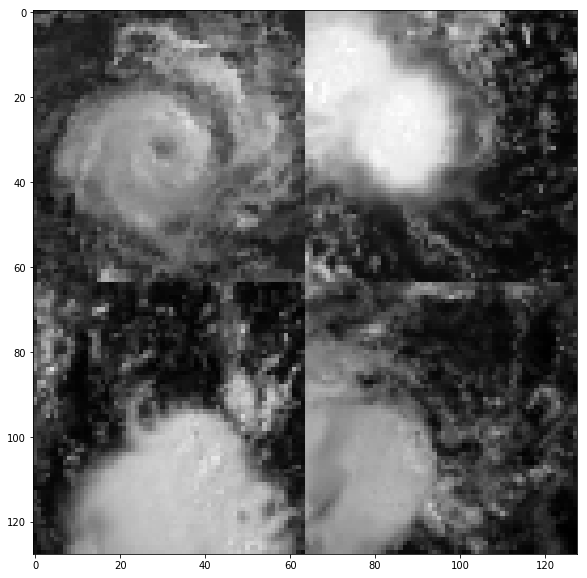

[0, 42, 361, 192, 401, 261, 87]


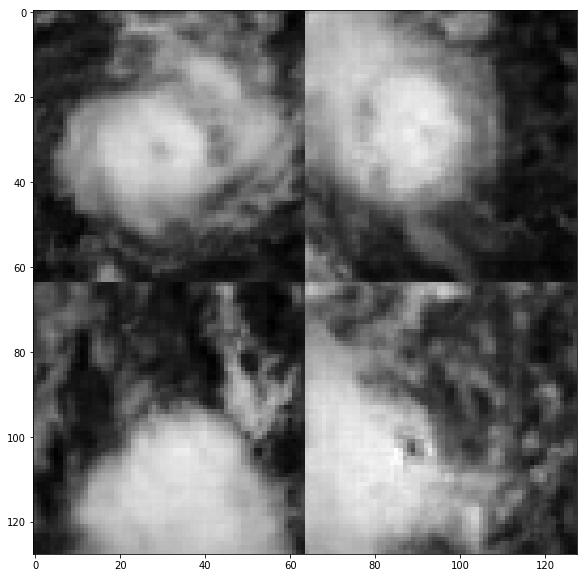

[0, 42, 361, 192, 401, 261, 87]


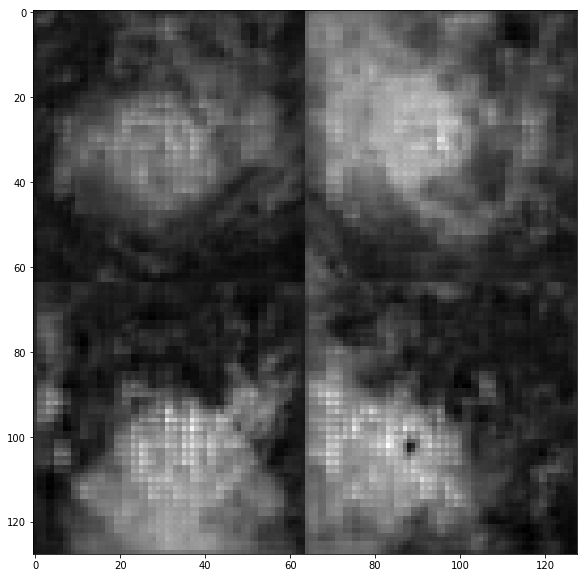

In [197]:
target_index=[0, 42, 361, 192, 401, 261, 87]

big_matrix = stick_into_big_matrix(sample_image, target_index, width=2)
plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()
#==========================
big_matrix = stick_into_big_matrix(L2_noon_image, target_index, width=2)
plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()
#==========================
big_matrix = stick_into_big_matrix(L1_noon_image, target_index, width=2)
plt.figure(figsize=(10,10))
plt.imshow(big_matrix, cmap='gray')
plt.show()

In [189]:
def compare_matrix(image, generated_image, target_index, width=5, height=2, target_channel_idx=3):
    random_select_num = width*height - len(target_index)
    bound = image.shape[0]
    random_index = [np.random.randint(bound) for i in range(random_select_num)]
    selected_index = target_index+random_index
    print(selected_index)
    selected_image1 = tf.gather(image, axis=0, indices=selected_index)
    selected_image2 = tf.gather(generated_image, axis=0, indices=selected_index)
    merged_images = np.concatenate([selected_image1, selected_image2], axis=2)
    squre_images = np.concatenate([merged_images[:, :, :, 2], scale_to_0_1(merged_images[:, :, :, 3])*1.5], axis=1)
    pad_w = 1
    padded_images = np.pad(squre_images, [ [0,0] , [pad_w, pad_w], [pad_w, pad_w]], constant_values=1.2)
    print(padded_images.shape)
    list_of_list_of_images = [
        [
            padded_images[i*height+j, :, :]
            for j in range(height)
        ] for i in range(width)
    ]
    list_of_lines = [
        tf.concat(
            list_of_images, axis=0
        ) for list_of_images in list_of_list_of_images
    ]
    return tf.concat(list_of_lines, axis=1)

[199, 203, 384, 292, 9, 226, 415, 122, 475, 172]
(10, 130, 130)


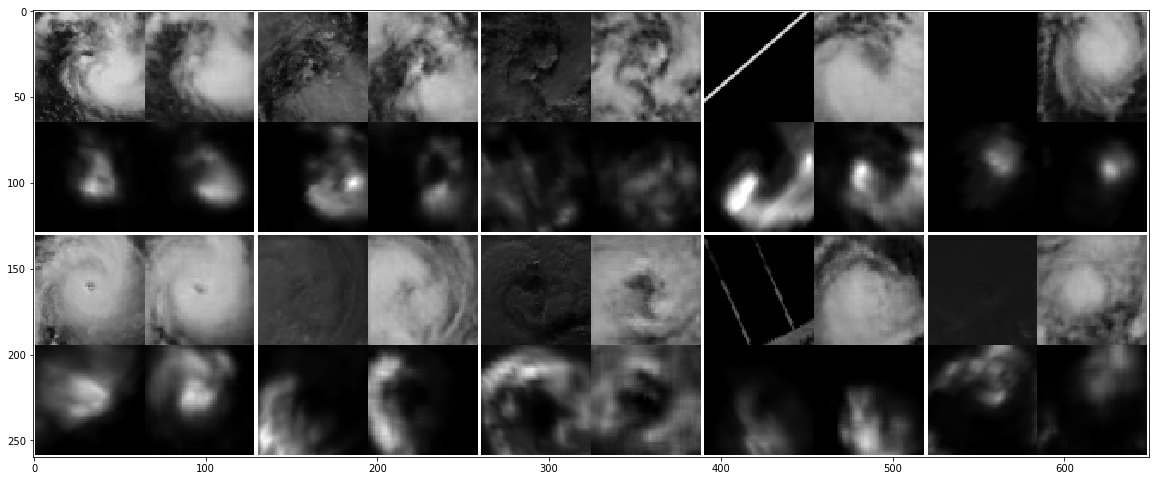

In [191]:
target_index=[199, 203, 384, 292, 9, 226, 415, 122, 475, 172]
[415, 292, 475, 226, 122, 9, 384, 485, 199, 69, 120, 203]

big_matrix = compare_matrix(sample_image, L2_noon_image, target_index)

plt.figure(figsize=(20,20))
plt.imshow(big_matrix, cmap='gray', vmin=0, vmax=1.2)
plt.show()

In [199]:
from modules.feature_generator import load_dataset

data_folder = 'TCSA_data/'
valid_data = load_dataset(data_folder, 'valid', good_VIS_only=False)
test_data = load_dataset(data_folder, 'test', good_VIS_only=False)

In [286]:
def get_minutes_to_noon(local_time):
    minutes_in_day = 60 * local_time.hour + local_time.minute
    noon = 60 * 12
    return abs(noon - minutes_in_day)

def wrapper_for_calculate_pred_Vmax(data_dict, compound_model, batch_size=100):
    image = data_dict['image']

    label_df = data_dict['label']

    feature_df = data_dict['feature']
    feature_df['minutes_to_noon'] = label_df['local_time'].apply(get_minutes_to_noon)
    feature = feature_df.to_numpy(dtype='float32')

    data_num = image.shape[0]
    result = []
    now_i = 0
    while now_i < data_num:
        end_i = now_i+batch_size
        result.append(
            rotation_blending(
                compound_model, 10,
                image[now_i:end_i],
                feature[now_i:end_i]
            )
        )
        now_i = end_i
    return tf.concat(result, axis=0)

In [314]:
def calculate_RMSE(label_df, column='pred_Vmax'):
    SE = (label_df['Vmax'] - label_df[column])**2
    MSE = SE.mean()
    RMSE = MSE ** 0.5
    return MSE, RMSE

In [289]:
def weighted_mean(value_queue):
    denominator = 0
    numerator = 0
    for i, weight in enumerate(range(5, 0, -1)):
        if len(value_queue) <= i:
            break
        denominator += weight
        numerator += value_queue[-1-i] * weight
    return float(numerator) / denominator

In [308]:
def calculate_smoothed_pred(label_df):
    now_ID = 'QAQ'
    result = []
    for i in range(label_df.shape[0]):
        now_row = label_df.loc[i]
        if now_ID != now_row['ID']:
            now_ID = now_row['ID']
            queue = []
        queue.append(now_row['pred_Vmax'])
        result.append(weighted_mean(queue))
    label_df['smoothed_pred'] = result

In [309]:
def evaluate(data_dict, model):
    label_df = data_dict['label']
    label_df['pred_Vmax'] = wrapper_for_calculate_pred_Vmax(data_dict, model)
    label_df['pred_Vmax'] = label_df['pred_Vmax'].apply(lambda x: x[0].numpy())
    calculate_smoothed_pred(label_df)
    print('no smothing', calculate_RMSE(label_df))
    print('smoothing', calculate_RMSE(label_df, 'smoothed_pred'))
    

In [310]:
evaluate(test_data, best_model)

no smothing (99.065206696413, 9.953150591466654)
smoothing (79.0526549240506, 8.89115599481027)


In [311]:
evaluate(valid_data, best_model)

no smothing (102.51965032558685, 10.125198779559186)
smoothing (74.35262281889676, 8.622796693584789)


In [312]:
evaluate(test_data, L2_compound_model)

no smothing (105.4779486335201, 10.27024579226418)
smoothing (87.10021733346771, 9.332749719855757)


In [313]:
evaluate(valid_data, L2_compound_model)

no smothing (108.98907227305571, 10.439783152587783)
smoothing (81.1731014348742, 9.009611613986154)
